In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline

import os
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
data_path = './GANdata/celeba'
#os.makedirs(data_path, exist_ok=True)
image_size = 64
num_workers = 2
batch_size = 32
data = datasets.ImageFolder(root=data_path,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [3]:
train_dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [4]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

#for check

torch.Size([32, 3, 64, 64]) torch.Size([32])


In [5]:
# Generator

class Generator(nn.Module):
    def __init__(self, nz, ngf, nc, img_size=(1, 28, 28)):
        super(Generator, self).__init__()
        self.nz = nz # 100, get noise vector of size 100 -> image. This is a simple model
        self.img_size = img_size # 1 x 28 x 28 for MNIST
        self.ngf = ngf
        self.nc = nc
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.nz, out_channels=self.ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=self.ngf * 8, out_channels=self.ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=self.ngf * 4, out_channels=self.ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=self.ngf * 2, out_channels=self.ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=self.ngf, out_channels=self.nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z):
        output = self.model(z)
        return output # 여기선 conv를 이용하므로 flatten이 필요 없음.

In [16]:
class Discriminator(nn.Module):
    def __init__(self, img_size, ndf, nc):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.ndf = ndf
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=ndf, out_channels=ndf*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=ndf*2, out_channels=ndf*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=ndf*4, out_channels=ndf*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=ndf*8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        output = self.model(img)
        return output

In [17]:

# check
z = torch.randn(32,100,1,1).to(device) # random noise
model_gen = Generator(100, ngf=64, nc=3, img_size=(3, 64, 64)).to(device)
# output = model_gen(z)
# print(output.shape)

x = torch.randn(32,3,64,64).to(device)
model_dis = Discriminator((3, 64, 64), ndf=64, nc=3).to(device)
# output = model_dis(x)
# print(output.shape)

In [18]:
def initialize_model(model):
    classname = model.__class__.__name__ # module name?
    print(classname)
    # conv layer
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02) # why?
        nn.init.constant_(model.bias.data, 0)


model_gen.apply(initialize_model)
model_dis.apply(initialize_model)
'''
Applies fn recursively to every submodule (as returned by .children()) as well as self. 
Typical use includes initializing the parameters of a model (see also torch.nn.init).
'''

ConvTranspose2d
BatchNorm2d
ReLU
ConvTranspose2d
BatchNorm2d
ReLU
ConvTranspose2d
BatchNorm2d
ReLU
ConvTranspose2d
BatchNorm2d
ReLU
ConvTranspose2d
Tanh
Sequential
Generator
Conv2d
BatchNorm2d
LeakyReLU
Conv2d
BatchNorm2d
LeakyReLU
Conv2d
BatchNorm2d
LeakyReLU
Conv2d
BatchNorm2d
LeakyReLU
Conv2d
Sigmoid
Sequential
Discriminator


'\nApplies fn recursively to every submodule (as returned by .children()) as well as self. \nTypical use includes initializing the parameters of a model (see also torch.nn.init).\n'

In [9]:
loss_fcn = nn.BCELoss()
# - (y_n * log(x_n) + (1 - y_n) * log(1 - x_n))
# y_n에 real / fake label, x_n에 discriminator의 output을 넣어서 의도한 loss를 구하기

In [10]:
# print(model_dis)
# print(model_gen)

In [19]:
from torch import optim # for optimization

lr = 2e-4
beta1 = 0.5
beta2 = 0.999

opt_D = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1, beta2))
opt_G = optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1, beta2))

In [12]:
real = 1
fake = 0
nz = 100
num_epoch = 5
loss_log = {'gen': [], 'dis': []}

In [28]:
import torchvision.utils as vutils
batch_count = 0
loss_log = {'gen': [], 'dis': []}
device="cuda"
fixed_noise = torch.randn(16, 100, 1, 1, device=device)
start_time = time.time()
# model_dis = model_dis.to(device)
# model_gen = model_gen.to(device)
model_dis.train()
model_gen.train()
img_list = []

for epoch in range(num_epoch):
    for i, data in enumerate(train_dataloader):
        x_batch = data[0].to(device)
        batch_size = len(x_batch)
        if batch_size != 32:
            print(batch_size)
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        

        # Discriminator step
        model_dis.zero_grad()
        #print(x_batch.device, x_batch.dtype)

        output_dis_real = model_dis(x_batch).reshape(-1)
        output_gen_fake = model_gen(noise)
        output_dis_fake = model_dis(output_gen_fake.clone().detach()).reshape(-1)
        y_batch_r = torch.ones((batch_size,)).to(device)
        y_batch_f = torch.zeros((batch_size,)).to(device)
        if batch_size != 32:
            print(output_dis_real.shape, y_batch_r.shape)
        loss_real = loss_fcn(output_dis_real, y_batch_r) # maximize log(D(x))
        loss_fake = loss_fcn(output_dis_fake, y_batch_f) # maximize 1 - log(D(G(z)))
        loss_dis = (loss_real + loss_fake) / 2
        loss_dis.backward()
        opt_D.step()
        
        # Generator step
        model_gen.zero_grad()
        #output_gen = model_gen(noise)
        output_dis = model_dis(output_gen_fake).reshape(-1)
        loss_gen = loss_fcn(output_dis, y_batch_r) # maximize log(D(G(z))), 본래는 log(1 - D(G(z)))를 minimize긴 한데 충분한 변화가 아님
        loss_gen.backward()
        opt_G.step()
        
        loss_log['gen'].append(loss_gen.item())
        loss_log['dis'].append(loss_dis.item())
        if (batch_count % 500 == 0) or ((epoch == num_epoch-1) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = model_gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
        
        
        #if batch_count % 50 == 0:
        if loss_gen > 10:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, batch_count: %d, time: %.2f min' %(epoch, loss_gen.item(), loss_dis.item(), batch_count, (time.time()-start_time)/60))
        batch_count += 1
        

Epoch: 0, G_Loss: 10.306795, D_Loss: 0.372483, batch_count: 11, time: 0.01 min
Epoch: 0, G_Loss: 10.134096, D_Loss: 0.226460, batch_count: 145, time: 0.06 min
Epoch: 0, G_Loss: 16.192528, D_Loss: 1.686082, batch_count: 294, time: 0.11 min
Epoch: 0, G_Loss: 12.170545, D_Loss: 1.172472, batch_count: 296, time: 0.11 min
Epoch: 0, G_Loss: 11.423962, D_Loss: 1.134368, batch_count: 298, time: 0.11 min
Epoch: 0, G_Loss: 10.497029, D_Loss: 0.082485, batch_count: 299, time: 0.11 min
Epoch: 0, G_Loss: 10.701832, D_Loss: 1.166243, batch_count: 301, time: 0.11 min
Epoch: 0, G_Loss: 11.753036, D_Loss: 0.469091, batch_count: 320, time: 0.12 min
Epoch: 0, G_Loss: 10.688793, D_Loss: 0.464602, batch_count: 323, time: 0.12 min
Epoch: 0, G_Loss: 13.420938, D_Loss: 0.666408, batch_count: 371, time: 0.14 min
Epoch: 0, G_Loss: 11.191072, D_Loss: 0.283124, batch_count: 410, time: 0.15 min
Epoch: 0, G_Loss: 14.545195, D_Loss: 0.723761, batch_count: 502, time: 0.19 min
Epoch: 0, G_Loss: 11.928455, D_Loss: 0.36

31660 113973


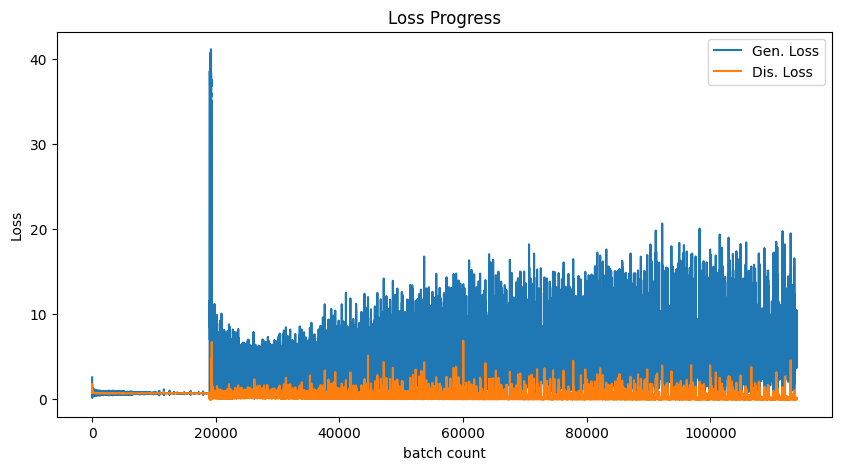

In [31]:
print(batch_count, len(loss_log['gen']))
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_log['gen'], label='Gen. Loss')
plt.plot(loss_log['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
save_path = './models'
os.makedirs(save_path, exist_ok=True)
torch.save(model_dis.state_dict(), save_path+'/DCGAN_discriminator.pt')
torch.save(model_gen.state_dict(), save_path+"/DCGAN_generator.pt")

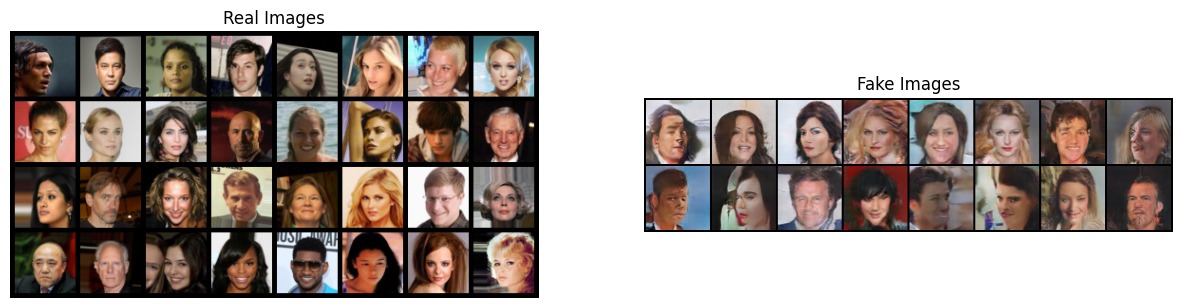

In [33]:

real_batch = next(iter(train_dataloader))


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 가짜 이미지들을 화면에 출력합니다
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
print(device)

cuda
